## Classifying Dropouts



This notebook documents the neural-network model we built to classify student dropouts. The dataset was retrieved from the UCI Machine Learning Repository. Because the data is modest in size, we completed the initial cleaning and EDA in Excel; additional preprocessing steps are recorded here, though most transformations were done before loading the data into Colab. The notebook focuses on the neural-network implementation; we also evaluated logistic regression and SVM baselines, and the neural network performed best. For full details on the dataset, methodology, results, and recommendations, please see the accompanying slide deck.

#### Further motivation
Dropouts are often stigmatized, and students who leave school are frequently labeled as “failures,” especially if they do not achieve notable success afterward. Rarely do we pause to consider the underlying factors that lead students to drop out, including the lack of institutional support they may face. Based on prior research and direct experience working with students—many of whom are first-generation college attendees (in particular, Xion Nelson from our team works closely with these students)—we chose this project to emphasize that the decision to drop out is complex and multifaceted. Our goal is to build a model that accurately classifies student dropouts in order to flag future students who may be at risk. In addition, we aim to identify the most influential features contributing to dropout, examine the backgrounds and characteristics of at-risk students, and propose actionable changes that can help institutions provide better support and ultimately improve retention rates.

In [1]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap

In [10]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
file_path = "/content/drive/MyDrive/predicting_dropout_dataset_updated.xlsx"
data = pd.read_excel(file_path)

#print(data.head())

Further data cleaning to ensure categorical variables are converted

In [13]:
# Change target variable to 1 or 0
data['target'] = data['target'].map({'Dropout': 1, 'No Dropout': 0})

# Separate explanatory and target variables
explanatory = data.drop(columns=['target']).values  # Convert to numpy array
target = data['target'].values.reshape(-1, 1)       # Reshape to column vector


Preparing the data to be trained by first splitting it into a train and test set

In [14]:
# Split data into training and test sets
explanatory_train, explanatory_test, target_train, target_test = train_test_split(
    explanatory, target, test_size=0.3, random_state=42
)

In [15]:

# Normalize the data
scaler = StandardScaler()
explanatory_train = scaler.fit_transform(explanatory_train)
explanatory_test = scaler.transform(explanatory_test)

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of sigmoid (for backpropagation)
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Initialize weights and biases
input_dim = explanatory_train.shape[1]
output_dim = 1
weights = np.random.randn(input_dim, output_dim) * 0.01  # Small random values
biases = np.zeros((1, output_dim))

# Hyperparameters
learning_rate = 0.9
epochs = 90

# To store losses
training_losses = []
test_losses = []


In [16]:

# Training loop
for epoch in range(epochs):
    # Forward pass (Training set)
    z_train = np.dot(explanatory_train, weights) + biases
    predictions_train = sigmoid(z_train)

    # Compute training loss (Binary Cross-Entropy)
    loss_train = -np.mean(target_train * np.log(predictions_train + 1e-7) + (1 - target_train) * np.log(1 - predictions_train + 1e-7))
    training_losses.append(loss_train)

    # Forward pass (Test set)
    z_test = np.dot(explanatory_test, weights) + biases
    predictions_test = sigmoid(z_test)

    # Compute test loss (Binary Cross-Entropy)
    loss_test = -np.mean(target_test * np.log(predictions_test + 1e-7) + (1 - target_test) * np.log(1 - predictions_test + 1e-7))
    test_losses.append(loss_test)

    # Backward pass (Gradient computation)
    d_loss_d_predictions = predictions_train - target_train                  # Gradient of loss w.r.t predictions
    d_predictions_d_z = sigmoid_derivative(z_train)                          # Gradient of sigmoid w.r.t z
    d_loss_d_z = d_loss_d_predictions * d_predictions_d_z                    # Chain rule: Loss gradient w.r.t z
    d_loss_d_weights = np.dot(explanatory_train.T, d_loss_d_z) / len(target_train)  # Loss gradient w.r.t weights
    d_loss_d_biases = np.sum(d_loss_d_z, axis=0, keepdims=True) / len(target_train) # Loss gradient w.r.t biases

    # Update weights and biases
    weights -= learning_rate * d_loss_d_weights
    biases -= learning_rate * d_loss_d_biases

    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Training Loss: {loss_train:.4f}, Test Loss: {loss_test:.4f}")

Epoch 0, Training Loss: 0.6901, Test Loss: 0.6891
Epoch 10, Training Loss: 0.5039, Test Loss: 0.5071
Epoch 20, Training Loss: 0.4574, Test Loss: 0.4619
Epoch 30, Training Loss: 0.4374, Test Loss: 0.4427
Epoch 40, Training Loss: 0.4266, Test Loss: 0.4327
Epoch 50, Training Loss: 0.4198, Test Loss: 0.4267
Epoch 60, Training Loss: 0.4153, Test Loss: 0.4228
Epoch 70, Training Loss: 0.4121, Test Loss: 0.4203
Epoch 80, Training Loss: 0.4097, Test Loss: 0.4185


Test Accuracy: 0.8351
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       818
           1       0.78      0.53      0.63       298

    accuracy                           0.84      1116
   macro avg       0.81      0.74      0.76      1116
weighted avg       0.83      0.84      0.82      1116

Confusion Matrix:
[[773  45]
 [139 159]]


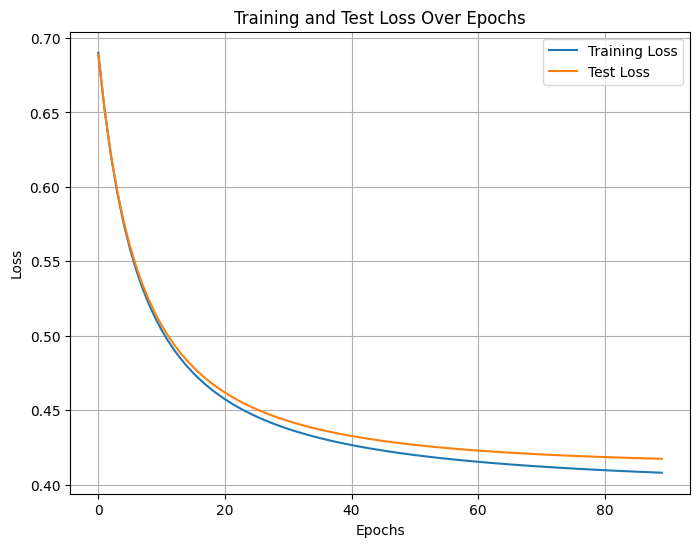

In [17]:
# Evaluate the model on the test set
predictions_test = (predictions_test > 0.5).astype(int)  # Convert probabilities to binary class

# Metrics
accuracy = accuracy_score(target_test, predictions_test)
print(f"Test Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(target_test, predictions_test))

print("Confusion Matrix:")
print(confusion_matrix(target_test, predictions_test))

# Plot Training and Test Loss
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), training_losses, label="Training Loss")
plt.plot(range(epochs), test_losses, label="Test Loss")
plt.title("Training and Test Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()



                                           Feature    Importance
20                curricular_units_1st_sem_(grade)  7.688172e-02
13                         tuition_fees_up_to_date  6.173835e-02
15                              scholarship_holder  7.347670e-03
16                               age_at_enrollment  7.168459e-03
24                                             GDP  4.569892e-03
12                                          debtor  3.046595e-03
18             curricular_units_1st_sem_(credited)  2.777778e-03
8                               fathers_occupation  2.240143e-03
7                               mothers_occupation  2.150538e-03
19          curricular_units_1st_sem_(evaluations)  1.971326e-03
2                                           course  1.164875e-03
9                                  admission_grade  1.075269e-03
1                                application_order  1.075269e-03
17                                   international  9.856631e-04
10                       

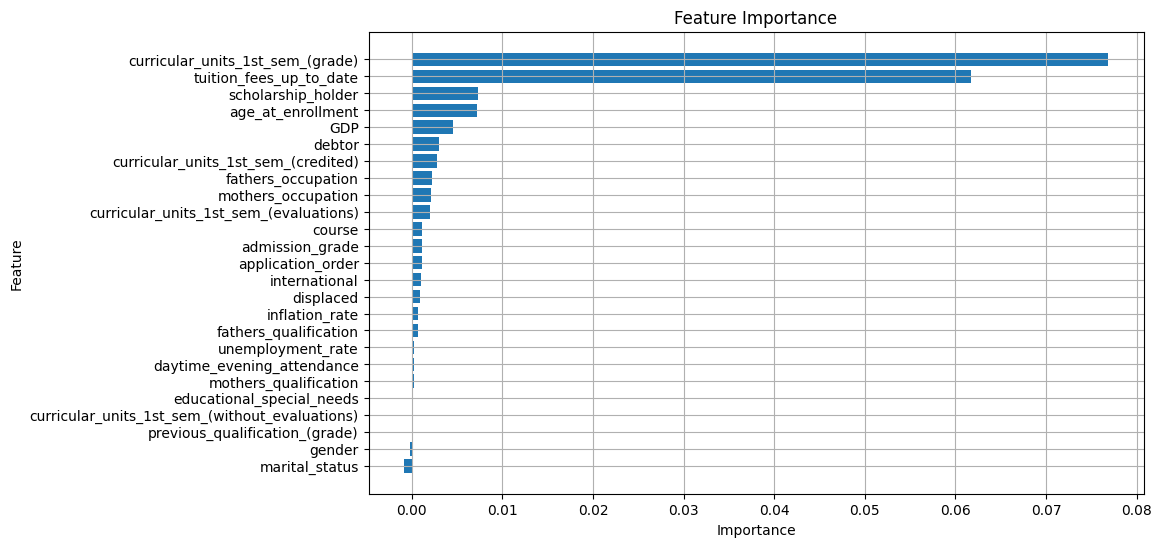

In [18]:
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define model_predict function
def model_predict(X):
    z = np.dot(X, weights) + biases
    return sigmoid(z)  # Return probabilities

# Permutation importance function
def permutation_importance(model_predict, X, y, metric=accuracy_score, n_repeats=10):
    baseline_score = metric(y, (model_predict(X) > 0.5).astype(int))
    feature_importances = np.zeros(X.shape[1])

    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])  # Shuffle values of one feature
            permuted_score = metric(y, (model_predict(X_permuted) > 0.5).astype(int))
            scores.append(baseline_score - permuted_score)
        feature_importances[i] = np.mean(scores)

    return feature_importances

# Compute feature importance
feature_importances = permutation_importance(model_predict, explanatory_test, target_test.flatten())

# Display feature importances
feature_names = data.drop(columns=['target']).columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.grid()
plt.show()